Import necessary libraries and various PREFFECT classes.

In [ ]:
import sys
import numpy as np
import torch

# path to main PREFFECT folder
sys.path.insert(0, '../../preffect')
from _config import configs # importing configuration from `_config.py`
from preffect_factory import factory
from _inference import( Inference )
from wrappers._cluster import( Cluster )

# limit threads
num_processors = 2
torch.set_num_threads(num_processors)
torch.set_num_interop_threads(num_processors)

You can set all of your PREFFECT variables within your script (as we do here), or set them in `_config.py` (which has also been imported)

In [2]:
# set up cuda (GPUs)
configs['no_cuda'] = False # False: Use GPU if found. True: Use CPU only.
configs['cuda_device_num'] = 6 # if you have multiple GPUs, select the GPU to use here

## code that reflects the exact conditions of a specific run
configs['task'] = 'train'
configs['seed'] = None

# Choose your PREFFECT model type
configs['type'] = 'full' # 'simple', 'single' or 'full'
configs['calT'] = 2 # number of tissues to include ("full" type only); automaticall set to 1 for 'simple' and 'single'

# latent space size
configs['h'] = 8 # number of heads
configs['r_prime'] = 128 # intermediate hidden dimension 
configs['r'] = 32 # size of latent space
configs['r_embed'] = 5 # size of the embedding space for categorical correction variables.

# learning parameters
configs['epochs'] = 1000  # Number of epochs during training
configs['mini_batch_size'] = 100  # num. of samples per minibatch

configs['lr'] = 0.0005  # learning rate
configs['weight_decay'] = 0.0005  # L2 loss on parameters
configs['dropout'] = 0.1  # dropout rate (1 - keep probability)
configs['alpha'] = 0.2  # leaky_relu parameter

configs['model_likelihood'] = 'NB' # NB or ZINB (the latter for data with high dropout rates)
configs['dispersion'] = 'gene-batch' # gene-sample or gene-batch

## Include additional variables within the model during training
configs['correct_vars'] = True
configs['vars_to_correct'] = [('batch', 'categorical')]
configs['set_NA_to_unique_corr'] = -1

# weights of losses
configs['kl_weight'] = 1
configs['DA_recon_weight'] = [100, 100]
configs['X_recon_weight'] = 100
configs['simple_KL_weight'] = [0.1]
configs['DA_KL_weight'] = [0.1, 0.1]
configs['X_KL_weight'] = [0.1, 0.1]

# weights for sample-sample adjacency edges
configs['pos_edge_weight'] = 1
configs['neg_edge_weight'] = 1

# weights that only apply when reconstructing library size
configs['lib_recon_weight'] = [100, 100]
configs['DL_KL_weight'] = [0.1, 0.1]

# We will not be trying to infer the library size in this vignette
configs['infer_lib_size'] = False

# Setting number of genes or samples to use (float('inf') uses all available data)
configs['select_samples'] = float('inf') # currently does not work for full models 
configs['select_genes'] = float('inf') # float('inf') uses all available genes
configs['select_sample_replacement'] = False # turn on if value of 'select_genes' is > than the total number of genes available

# Data Masking (MCARS) to prevent overfitting
configs['masking_strategy'] = 'MCAR' # None or 'MCAR'
configs['lambda_counts'] = 0.1
configs['lambda_edges'] = 0.0

# Variables which prevent extreme values; specific maximums (i.e. 'clamps') are found in '_config.py'
configs['theta_transform'] = True 
configs['gradient_clip'] = True # gradient clipping is highly recommended

# more parameters can be found in `_config.py`

In [ ]:
# set input/output data
configs['input_anndata_path'] = '../vignettes/full/'
configs['input_inference_anndata_path'] = configs['input_anndata_path'] + 'train/'
configs['output_path'] = './vignettes/vignette_output/'

Now that our parameters have been set up, we call the factory to bein training our 'full' (multi-tissue) model. 

Training Progress: 100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


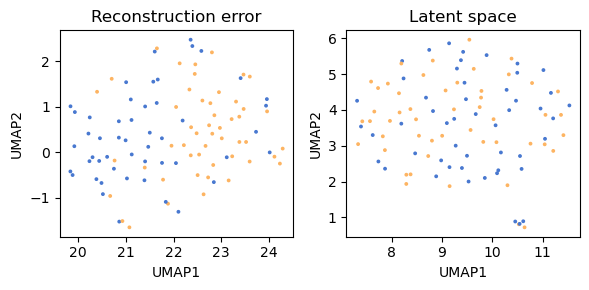

In [4]:
preffect_object = factory(
    configs=configs.copy(), 
    task='train', 
    always_save = True
)

Now that training is complete, we can import the inferred results (where the model has been fed the original training data) into our session.

We use the function `return_counts_as_anndata()` to load these results as an AnnData structure for downstream analyses.

In [5]:
# PREFFECT automatically performs endogenous inference (using input data) after training, which can be found within `preffect_object.inference_dict['endogenous']`
inf_obj = preffect_object.inference_dict['endogenous']
adata_test = inf_obj.return_counts_as_anndata()
print(adata_test[0].obs) # viewing the metadata of the synthetic samples (where batch assignments can be read)

         batch
tau1_0     0.0
tau1_1     1.0
tau1_2     1.0
tau1_3     0.0
tau1_4     1.0
...        ...
tau1_95    0.0
tau1_96    0.0
tau1_97    1.0
tau1_98    0.0
tau1_99    0.0

[100 rows x 1 columns]


PREFFECT includes built-in clustering functions that create UMAPs.

Here, we create a UMAP of the synthetic counts used as training data for our derived PREFFECT model.

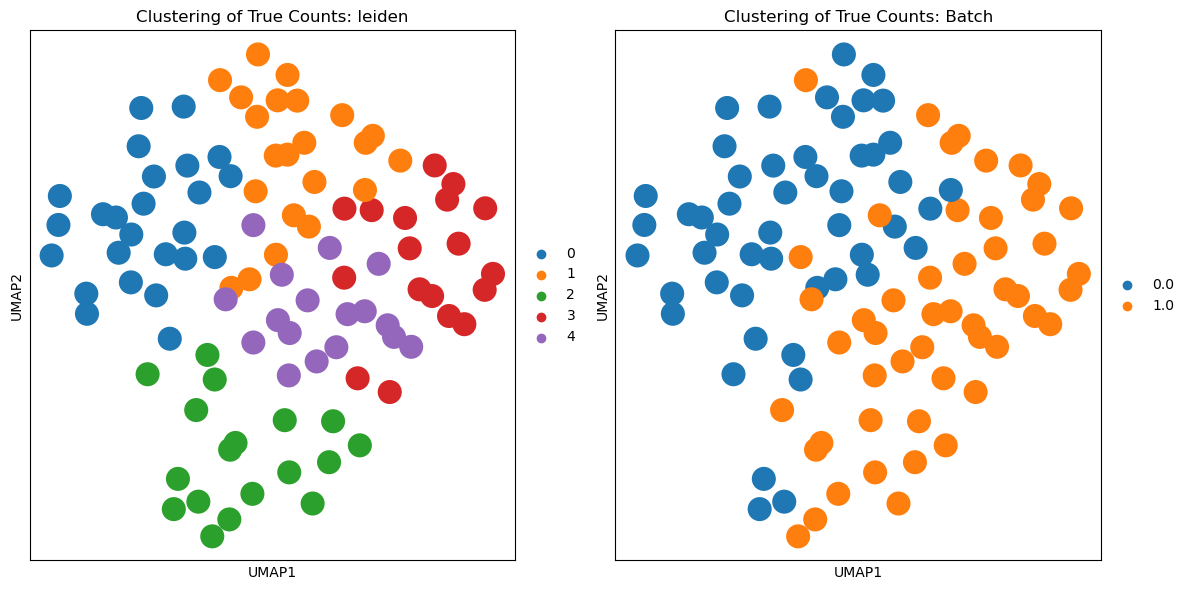

In [ ]:
# Cluster counts used as input when training the PREFFECT model (observed or "true" counts)
factory(
    task='cluster_true_counts', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )

We can also cluster the counts inferred by the PREFFECT model after endogenous inference.

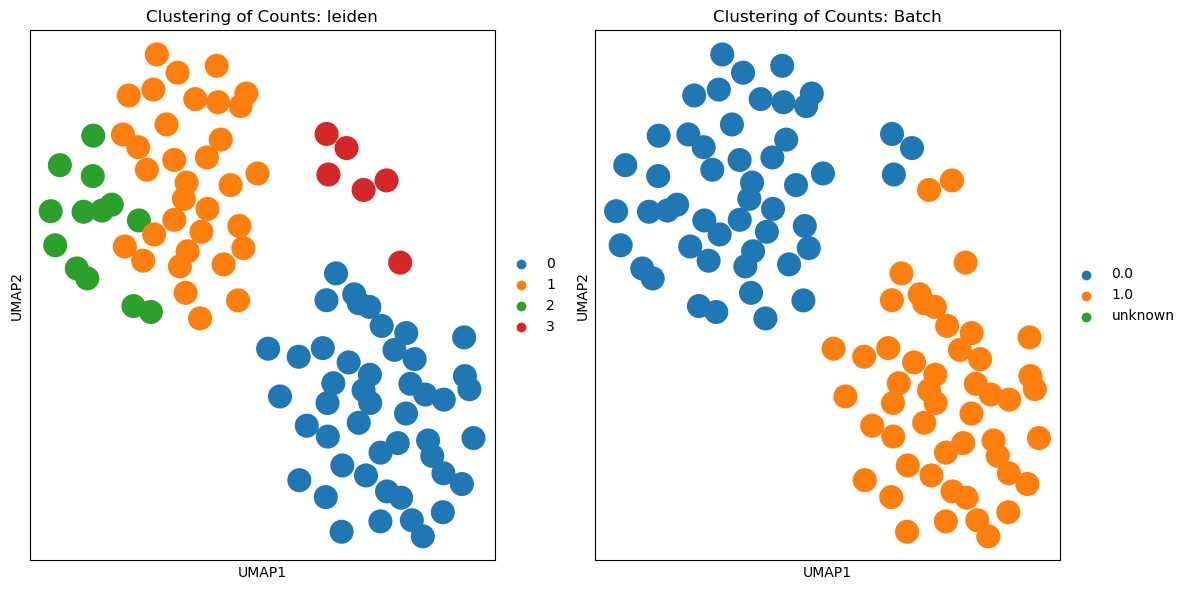

In [ ]:
# Cluster counts estimated by the PREFFECT model
factory(
    task='cluster_counts', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )

# alternatively, you can call the clustering functions directly, which allows you to modify some of the UMAP parameters
# inference_object = preffect_object.inference_dict['endogenous'] 
# cl = Cluster(infer_obj=inference_object, configs_cluster=configs)
# cl.cluster_counts(color_by = "leiden", umap_nneighbors=20, cluster_aim=5)

We can similarly visualize the latent space in this way.

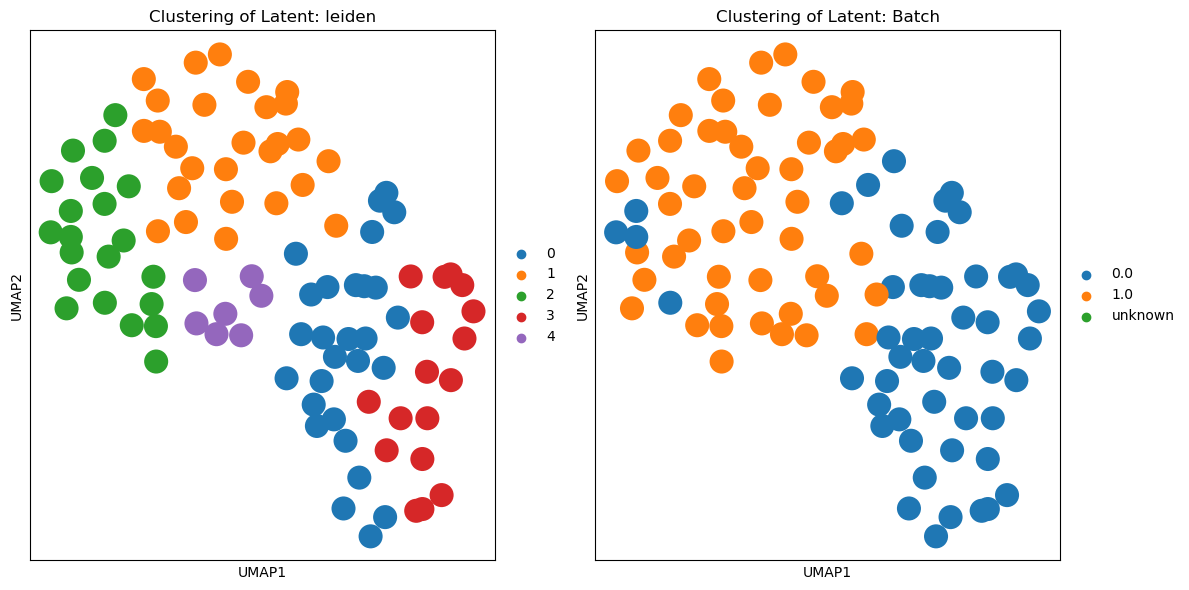

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cluster the latent space of expression
factory(
    task='cluster_latent', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )

# alternatively, you can call the clustering functions directly, which allows you to modify some of the UMAP parameters
# inference_object = preffect_object.inference_dict['endogenous'] 
# cl = Cluster(infer_obj=inference_object, configs_cluster=configs)
# cl.cluster_latent_space(color_by = "leiden", umap_nneighbors=10, cluster_aim=5)

PREFFECT allows one to adjust the model to treat all samples as if it were derived from a particular batch. In this dataset, two batches exist (batch 0.0 and 1.0). Here, we will set samples to all resemble "batch 0.0".

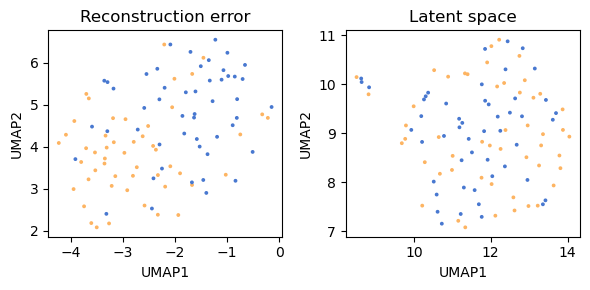

In [9]:
configs['adjust_vars'] = True, 
configs['adjust_to_batch_level'] = 0.0
 
inference_object = factory(
    task='inference', 
    configs=configs, 
    preffect_obj=preffect_object
)
# you will find the batch-level adjusted inference here: inference_object.inference_dict['inference_0.0']